In [2]:
from itertools import product
from functools import partial
from typing import List, Tuple, Callable, Dict
from collections import namedtuple

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from synchronizer.range_matcher.estimator import estimate_losses
from synchronizer.range_matcher.run_synch_estim_pair import rel_mean_dist_err, run_synch_estim_pair
from generator.sequence import generate_random_sequence
from simulator.live.loss import ge_loss
from synchronizer.exceptions import SynchronizationError
from synchronizer.range_matcher.range_matcher import get_range_matcher
from signal_utils.sample import sample_lognormal

ModuleNotFoundError: No module named 'synchronizer'

`range_matcher` tries to match ranges of a certain width of the reference to ranges of the signal. 

Suppose we use a symbol size of two bits (per packet). We want to find out how different range widths affect the recovery of the lost positions under different loss rates.

We use the Gilbert-Elliot loss model. These will be our configurations:

In [ ]:
loss_rates = [0.01, 0.02, 0.05, 0.10]
ge_configurations = {
    key: {kw: param for kw, param in zip(('move_to_bad','move_to_good','drop_in_bad',
        'drop_in_good'), conf)} for key, conf in zip(loss_rates, [
        (0.005, 0.7, 0.5, 0.0075), #  1% loss
        (0.01, 0.75, 0.8, 0.01),   #  2% loss
        (0.035, 0.75, 0.8, 0.02),  #  5% loss
        (0.075, 0.75, 0.8, 0.03),  # 10% loss
    ])
}

These will be our range widths:

In [ ]:
range_widths = [4, 8, 16]

We'll draw lenghts of flows from a log-normal distribution:

In [ ]:
mu, sigma = 3, 1

def sample_flow_length():
    return sample_lognormal(mu, sigma)

As a proxy for accuracy of the prediction, we use the the relative error in the mean inter-loss distance between the actual and the predicted loss indices.

In [ ]:
Sample = namedtuple('Sample', ['range_width', 'loss_rate', 'rel_mean_dist_err',
                               'reference_length', 'loss_count', 'rejected'])


def run_experiment(run_synch_estim: Callable, runs: int) -> pd.DataFrame:
    samples = []
    for _ in range(1000):
        for range_width, (loss_rate, ge_conf) in product(range_widths, ge_configurations.items()):
            reference_length = sample_flow_length()
            try:
                expected, actual = run_se_rand_seq(get_range_matcher(range_width),
                                                   policies=[partial(ge_loss, **ge_conf)],
                                                   reference_length=reference_length)
            except SynchronizationError:
                samples.append(Sample(range_width=range_width,
                                      loss_rate=loss_rate,
                                      rel_mean_dist_err=0,
                                      reference_length=reference_length,
                                      loss_count=0,
                                      rejected=True))
                continue

            samples.append(Sample(range_width=range_width,
                                  loss_rate=loss_rate,
                                  rel_mean_dist_err=rel_mean_dist_err(expected, actual),
                                  reference_length=reference_length,
                                  loss_count=len(expected),
                                  rejected=False))
    return pd.DataFrame(samples)

In [ ]:
run_se_rand_seq = partial(run_synch_estim_pair,
                          estimator=estimate_losses,
                          reference=generate_random_sequence(2))  # symbol_bits

samples_df = run_experiment(run_se_rand_seq, 10000)

What's the distribution of flow lengths?

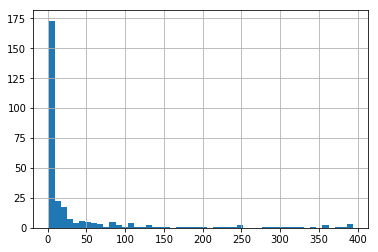

In [ ]:
samples_df['reference_length'].value_counts().hist(bins=50)

We'll plot the empirical CDF of the relative mean distance error.

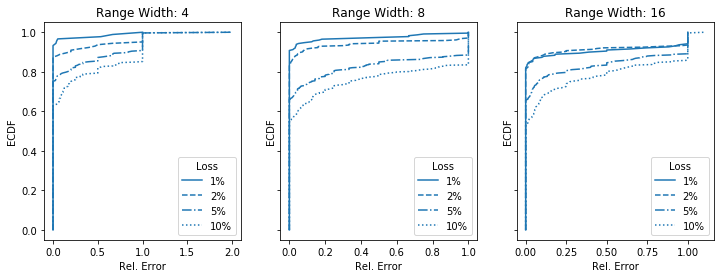

In [ ]:
Line = namedtuple('Line', ['style', 'color'])

def multi_ecdf_plot(samples_df: pd.DataFrame,
                    samples_to_titles_labels_values: Callable[
                        [pd.DataFrame], List[Tuple[str, List[Tuple[str, pd.Series]]]]],
                    lines: Dict[str, Line] = None,
                    xlabel: str = '',
                    legend_title: str = ''):
    titles_labels_values = samples_to_titles_labels_values(samples_df)
    num_subplots = len(titles_labels_values)
    fig, axes = plt.subplots(nrows=1, ncols=num_subplots, figsize=(4 * num_subplots, 4),
                             sharey=True)
    for i, (title, labels_values) in enumerate(titles_labels_values):
        ecdf_subplot(labels_values, 
                     ax=axes[i], 
                     lines=lines, 
                     title=title, 
                     xlabel=xlabel,
                     legend_title=legend_title)
       
        
def samples_to_titles_labels_values(df: pd.DataFrame) ->  List[Tuple[str,List[Tuple[str, pd.Series]]]]:
    return [(f'Range Width: {range_width}', 
             [('{:.0f}%'.format(loss_rate * 100), gg_df['rel_mean_dist_err']) for loss_rate, gg_df in g_df.groupby('loss_rate')]
            ) for range_width, g_df 
            in samples_df[samples_df['loss_count'] > 0].groupby('range_width')]


default_line = Line(style='-', color='#1f77b4')


def ecdf_subplot(labels_values: List[Tuple[str, pd.Series]],
                 ax=None,
                 lines: Dict[str, Line] = None,
                 title: str = '',
                 xlabel: str = '',
                 xlim=None,
                 legend_title: str = ''):
    assert ax is not None, 'Axis needs to be provided.'
    for label, values in labels_values:
        line = lines.get(label, default_line)
        ax.plot(ecdf(values),
                label=label,
                linestyle=line.style,
                color=line.color)
    ax.set_ylabel('ECDF')
    ax.set_xlabel(xlabel)
    ax.set_xlim(xlim)
    ax.set_title(title)
    ax.legend(title=legend_title)
    
def ecdf(series: pd.Series) -> pd.Series:
    series = series.sort_values()
    cdf = np.linspace(0.,1.,len(series))
    return pd.Series(cdf, index=series)    
    
multi_ecdf_plot(samples_df, 
                samples_to_titles_labels_values, 
                lines={key: Line(style, '#1f77b4') 
                       for key, style in [('1%', '-'),('2%', '--'),('5%', '-.'),('10%', ':')]},
                xlabel='Rel. Error',
                legend_title='Loss')

With the shortest range width, we get the closest loss index predictions to the result. However, this only takes into account runs where the synchronizer did not raise `SynchronizationError`. How many were dropped?

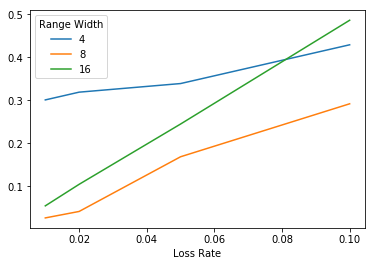

In [ ]:
agg_df = samples_df.groupby(['loss_rate', 'range_width']).agg({
    'rejected': 'mean'
}).unstack(1)
agg_df.columns = [col[1] for col in agg_df.columns]
agg_df.columns.name = 'Range Width'
agg_df.index.name = 'Loss Rate'
agg_df.plot()

A range of 4 is too short: There is more ambiguity, so ranges are easily confused if an error occurs. With 16 packet ranges, on the other hand, in presence of errors, fewer ranges will be left untouched.